In [1]:
# Data analysis & wrangling
import numpy as np # linear algebra
import pandas as pd # data processing
import random as rnd
import string
import requests
import re

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


from tqdm import tqdm
from collections import Counter
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from collections import defaultdict
from pymorphy2 import MorphAnalyzer
from collections import Counter
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import spacy
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


2022-12-06 18:36:42.664889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Amazon products reviews

In [2]:
df = pd.read_csv('/Users/Varvara/spiced_working_files/final_project/NLP/reviews_full_text.csv')
df


,asin,text,title,location_and_date,verified,rating,negative or positive
0,B07HBDNGHC,Auf die Funktion der Box gehe ich nur kurz ein...,"Die Toniebox: sehr teuer, sehr geliebt",Reviewed in Germany on 10 October 2022,True,4.0,positive
1,B07HBDNGHC,Ich hielt die Toniebox immer für einen Überteu...,Neutrale Bewertung der Toniebox nach über eine...,Reviewed in Germany on 2 April 2020,False,4.0,positive
2,B07HBDNGHC,"Die Box ist ein hübsches Gerät, leider ist sie...","Schönes Teil, leider nicht so robust wie gedacht",Reviewed in Germany on 22 November 2022,True,5.0,positive
3,B07HBDNGHC,Hier muss ich einfach bewerten!!!Bin super zuf...,Toniebox ist einfach super,Reviewed in Germany on 21 November 2022,True,5.0,positive
4,B07HBDNGHC,Wir Lieben die toniebox. Sie ist mega praktisc...,100% Empfehlung,Reviewed in Germany on 28 November 2022,True,5.0,positive
...,...,...,...,...,...,...,...
5958,B000NJWLHS,"Super schnelle Lieferung ,hervorragende Qualit...",Tolles Weinachtsgescheng,Reviewed in Germany on 8 January 2022,True,5.0,positive
5959,B000NJWLHS,Unsere Enkeltochter hat es zum Geburtstag beko...,Super Geburtstagsgeschenk,Reviewed in Germany on 19 May 2021,True,5.0,positive
5960,B000NJWLHS,"Die Farben waren teilweise angetrocknet, so da...",Farben teilweise angetrocknet,Reviewed in Germany 🇩🇪 on 22 January 2021,True,3.0,positive
5961,B000NJWLHS,an Amazon: aus dem Programm nehmen!,"völlig ungeeignet,",Reviewed in Germany 🇩🇪 on 18 June 2020,True,1.0,positive


In [3]:
df.isnull().sum().sort_values(ascending=False)

asin                    0
text                    0
title                   0
location_and_date       0
verified                0
rating                  0
negative or positive    0
dtype: int64

In [4]:
df["text"].fillna("kein Kommentar", inplace = True)
df["location_and_date"].fillna("leer", inplace = True)

In [5]:
df.to_csv('reviews_full_text.csv',index=False)

### Good reviews

In [6]:
print(stopwords.words('german'))

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an', 'ander', 'andere', 'anderem', 'anderen', 'anderer', 'anderes', 'anderm', 'andern', 'anderr', 'anders', 'auch', 'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies', 'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges', 'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin', 'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euc

In [7]:
df['reviews']=df['text']+df['title']
df['reviews'][0]

'Auf die Funktion der Box gehe ich nur kurz ein, da die Toniebox doch sehr bekannt ist und das Prinzip sogar für einen 2 jährigen leicht verständlich ist.Die Box wurde schnell geliefert, gibt es in schönen Farben (beim starter Set mit kreativ Tonie), ist nicht zu groß, so das kleine Kinder es gut herumtragen können, ist Ummantelt mit leicht gefütterten robusten Stoff und somit recht robust und auch sicher für Kinder.Es hat 2 Ohren für laut und leise.Für das Einrichten wird WLan benötigt. Wird ein Tonie drauf gesetzt, spielt es direkt ab. Leuchtet es blau, so wird der Inhalt während dem abspielen herunter geladen. Grün bedeutet alles super und rot/Orange das die Batterie bald alle ist.Haut man seitlich auf die Box so kann man ein Kapitel vor oder zurück springen.Der Ton ist an sich okay bis gut aber nicht herausragend und für den hohen Preis gerade noch akzeptabel.Die Figuren dafür sind niedlich und werden ebenfalls gerne bespielt. Nachteil hier ist, dass die Farbe der Tonies bei uns St

In [8]:
mystem = Mystem() 
german_stopwords = stopwords.words("german")
new_stopwords=['spielzeug', 'spiel']
german_stopwords.extend(new_stopwords)


def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in german_stopwords\
              and token != " " \
              and token.strip() not in punctuation+'«»“•' \
              and '\n' not in token]
    
    text = " ".join(tokens)
    
    return text

In [9]:
df['reviews'] = df['reviews'].astype(str)
df['reviews'] = df['reviews'].apply(preprocess_text)
df['reviews']

0       funktion box gehe kurz toniebox bekannt prinzi...
1       hielt toniebox immer überteuerten lautsprecher...
2       box hübsches gerät leider robust gerät kinder ...
3       einfach bewerten !!! super zufrieden toniebox ...
4       lieben toniebox mega praktisch super leicht be...
                              ...                        
5958    super schnelle lieferung hervorragende qualitä...
5959    enkeltochter geburtstag bekommen darüber riesi...
5960    farben teilweise angetrocknet tochter neu anrü...
5961             amazon programm nehmen völlig ungeeignet
5962    proprio l idea di essere stato spedito già rov...
Name: reviews, Length: 5963, dtype: object

In [10]:
text = ' '.join(df['reviews'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:50]

[(('🔷', '🔶', '🔷', '🔶', '🔷'), 18),
 (('🌿', '⭐', '🌿', '⭐', '🌿'), 18),
 (('⭐', '🌿', '⭐', '🌿', '⭐'), 16),
 (('🌸', '⚓', '🌸', '⚓', '🌸'), 15),
 (('🔶', '🔷', '🔶', '🔷', '🔶'), 15),
 (('⚓', '🌸', '⚓', '🌸', '⚓'), 13),
 (('ravensburger', 'tiptoi', 'starter', 'set', '00112'), 5),
 (('👍', '🏻', '👍', '🏻', '👍'), 4),
 (('🏻', '👍', '🏻', '👍', '🏻'), 4),
 (('プ', 'レ', 'ゼ', 'ン', 'ト'), 4),
 (('👍', '🏼', '👍', '🏼', '👍'), 4),
 (('🏼', '👍', '🏼', '👍', '🏼'), 4),
 (('fire', 'hd', '10', 'kids', 'pro'), 4),
 (('⭐', '⭐', '⭐', '⭐', '⭐'), 3),
 (('5', 'sterne', 'dafür', 'top', '!!!'), 3),
 (('ravensburger', '76301', 'thinkfun', 'rush', 'hour'), 3),
 (('it', '’', 's', 'advent', 'calendar'), 3),
 (('レ', 'ゼ', 'ン', 'ト', 'に'), 3),
 (('し', 'ま', 'し', 'た', '。'), 3),
 (('roll', 'your', 'puzzle', 'xxl', 'system'), 3),
 (('wmf', 'kult', 'x', 'mix', 'go'), 3),
 (('1', 'rocky', 'baden2', 'große', 'herbstfest3'), 2),
 (('rocky', 'baden2', 'große', 'herbstfest3', 'rettung'), 2),
 (('baden2', 'große', 'herbstfest3', 'rettung', 'meeresschildkröt

In [11]:
my_list = Counter(text_trigrams)
my_list

Counter({('funktion', 'box', 'gehe', 'kurz', 'toniebox'): 1,
         ('box', 'gehe', 'kurz', 'toniebox', 'bekannt'): 1,
         ('gehe', 'kurz', 'toniebox', 'bekannt', 'prinzip'): 1,
         ('kurz', 'toniebox', 'bekannt', 'prinzip', 'sogar'): 1,
         ('toniebox', 'bekannt', 'prinzip', 'sogar', '2'): 1,
         ('bekannt', 'prinzip', 'sogar', '2', 'jährigen'): 1,
         ('prinzip', 'sogar', '2', 'jährigen', 'leicht'): 1,
         ('sogar', '2', 'jährigen', 'leicht', 'verständlich'): 1,
         ('2', 'jährigen', 'leicht', 'verständlich', 'box'): 1,
         ('jährigen', 'leicht', 'verständlich', 'box', 'wurde'): 1,
         ('leicht', 'verständlich', 'box', 'wurde', 'schnell'): 1,
         ('verständlich', 'box', 'wurde', 'schnell', 'geliefert'): 1,
         ('box', 'wurde', 'schnell', 'geliefert', 'gibt'): 1,
         ('wurde', 'schnell', 'geliefert', 'gibt', 'schönen'): 1,
         ('schnell', 'geliefert', 'gibt', 'schönen', 'farben'): 1,
         ('geliefert', 'gibt', 'sch

### CountVector

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [13]:
# splitting the data
X = df['reviews']
y = df['asin']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
X_train.shape,y_train.shape

((4472,), (4472,))

In [16]:
cv = CountVectorizer(stop_words='english', max_df=0.8)# substitute stopwords 
X_cv = cv.fit_transform(X)
X_df = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names_out(), index=y)
X_df.head()

,00,000,00110,00112,007,01,01s,02,03,04,...,übungssache,üppigem,üppigen,üß,üüüberall,české,češtinanemá,świetna,şekilde,że
asin,,,,,,,,,,,,,,,,,,,,,
B07HBDNGHC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B07HBDNGHC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B07HBDNGHC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B07HBDNGHC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B07HBDNGHC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_cv.shape

(5963, 27851)

In [18]:
#cv.get_feature_names()

In [19]:
cv.vocabulary_

{'funktion': 9001,
 'box': 4278,
 'gehe': 9516,
 'kurz': 14031,
 'toniebox': 23577,
 'bekannt': 3454,
 'prinzip': 18486,
 'sogar': 21422,
 'jährigen': 12682,
 'leicht': 14509,
 'verständlich': 25342,
 'wurde': 26736,
 'schnell': 20540,
 'geliefert': 9679,
 'gibt': 10398,
 'schönen': 20828,
 'farben': 8127,
 'beim': 3427,
 'starter': 22314,
 'set': 21087,
 'kreativ': 13849,
 'tonie': 23576,
 'groß': 10733,
 'kleine': 13328,
 'kinder': 13045,
 'gut': 10897,
 'herumtragen': 11452,
 'ummantelt': 24088,
 'gefütterten': 9462,
 'robusten': 19699,
 'stoff': 22571,
 'somit': 21480,
 'recht': 19191,
 'robust': 19694,
 'sicher': 21148,
 'ohren': 17151,
 'laut': 14374,
 'leise': 14541,
 'einrichten': 6690,
 'wlan': 26600,
 'benötigt': 3575,
 'drauf': 5975,
 'gesetzt': 10137,
 'spielt': 22025,
 'direkt': 5768,
 'ab': 518,
 'leuchtet': 14648,
 'blau': 4106,
 'inhalt': 12225,
 'abspielen': 781,
 'herunter': 11454,
 'geladen': 9621,
 'grün': 10848,
 'bedeutet': 3210,
 'super': 22842,
 'rot': 19754,
 '

In [20]:
tf = TfidfTransformer()# apply TF-IDF Vectorizer
X_norm = tf.fit_transform(X_cv)# creating sparse matrix 

In [21]:
print(X_norm)

  (0, 27428)	0.06233565754076885
  (0, 27282)	0.05036361972001553
  (0, 26926)	0.06971997923934471
  (0, 26736)	0.03887767300787725
  (0, 26600)	0.07574375133939552
  (0, 26341)	0.09223763895642577
  (0, 26224)	0.09223763895642577
  (0, 25518)	0.050714020641526136
  (0, 25342)	0.06233565754076885
  (0, 25106)	0.04369999464206617
  (0, 25009)	0.09223763895642577
  (0, 24636)	0.05945690568495394
  (0, 24088)	0.09223763895642577
  (0, 23584)	0.23461084253047831
  (0, 23577)	0.12764703192763602
  (0, 23576)	0.1460942657442951
  (0, 23571)	0.07030575172982742
  (0, 23453)	0.07030575172982742
  (0, 23344)	0.06916588599691058
  (0, 23343)	0.08513410820827381
  (0, 23323)	0.04664822627982953
  (0, 22842)	0.030214445747615015
  (0, 22669)	0.07574375133939552
  (0, 22571)	0.0686402205912436
  (0, 22421)	0.05565625194781737
  :	:
  (5961, 1282)	0.3387446753036838
  (5962, 22419)	0.19173224379963513
  (5962, 22346)	0.16504494070951845
  (5962, 21702)	0.19173224379963513
  (5962, 21564)	0.191732243

In [22]:
#transforming X_test
X_norm_trans=tf.transform(X_norm).toarray()
X_norm_trans

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# converting sparse matrix into a dense matrix to view it effectively
tf_vectors=pd.DataFrame(X_norm.todense().round(2), columns=cv.get_feature_names()) 

In [24]:
tf_vectors.head()

,00,000,00110,00112,007,01,01s,02,03,04,...,übungssache,üppigem,üppigen,üß,üüüberall,české,češtinanemá,świetna,şekilde,że
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### WordCloud

In [25]:
#text=pd.read_csv("lego_bad_reviews.txt", sep=" ")
text=df['reviews'][0]

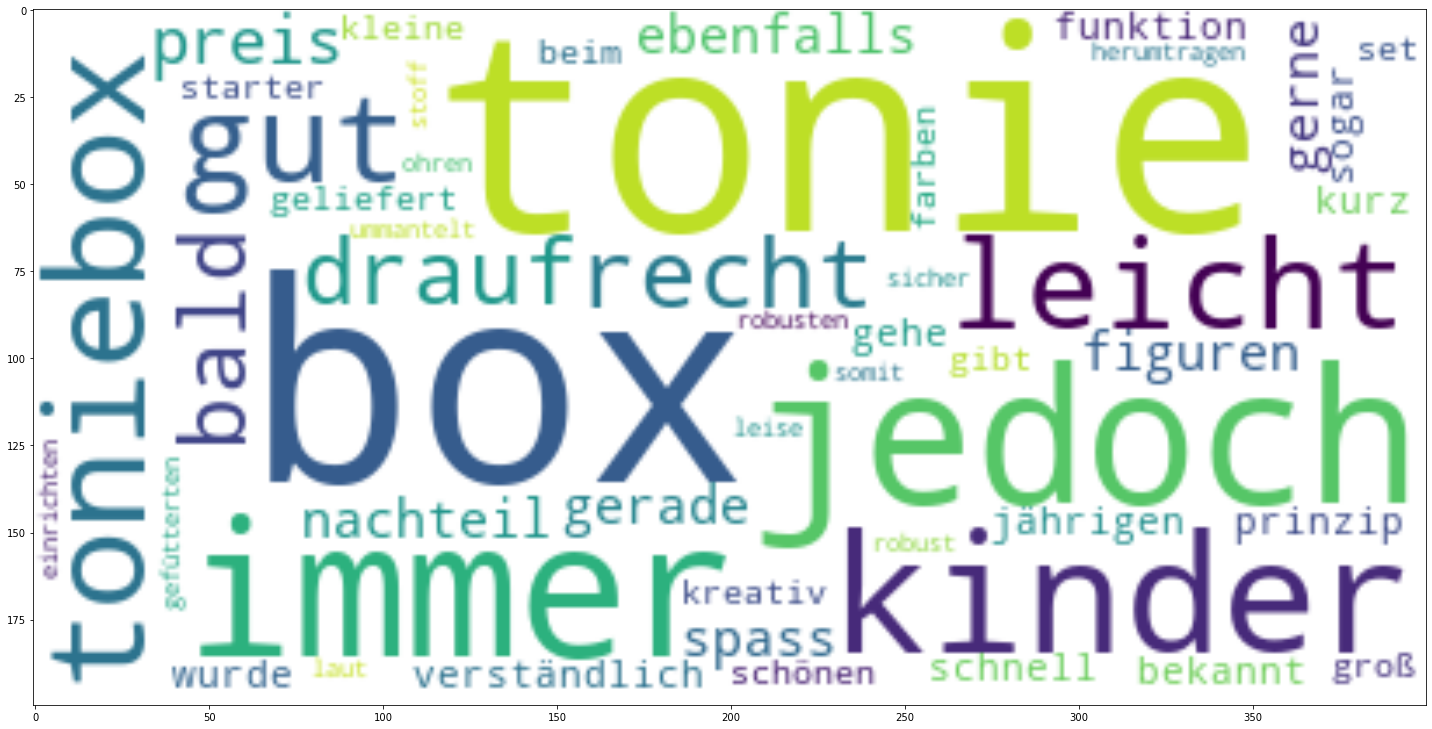

In [26]:
mask = np.zeros((500, 600, 3), np.uint8)
mask[150:350,150:350,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                #mask=mask,
                collocations=False,  # calculates frequencies
                contour_color='steelblue').generate(text)
                # stop words are removed!

plt.figure(figsize = (20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad = 1.08)# important feature(without it there is a empty space in the middle)
plt.savefig('cloud1.png')
plt.show()

In [27]:
text1=df['reviews'][1]

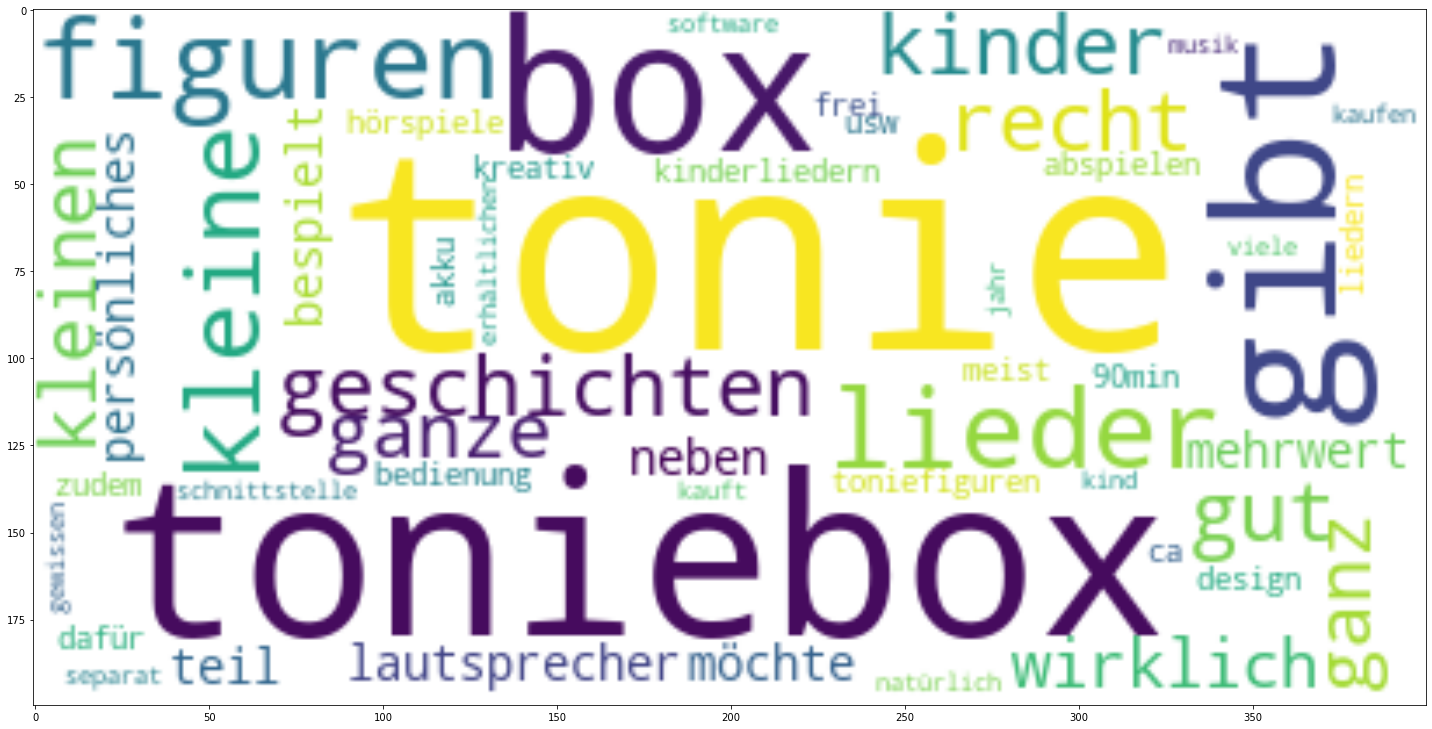

In [28]:
mask = np.zeros((500, 600, 3), np.uint8)
mask[150:350,150:350,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                #mask=mask,
                collocations=False,  # calculates frequencies
                contour_color='steelblue').generate(text1)
                # stop words are removed!

plt.figure(figsize = (20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad = 1.08)# important feature(without it there is a empty space in the middle)
plt.savefig('cloud.png')
plt.show()

### LDA

In [29]:
from langdetect import detect
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [30]:
df

,asin,text,title,location_and_date,verified,rating,negative or positive,reviews
0,B07HBDNGHC,Auf die Funktion der Box gehe ich nur kurz ein...,"Die Toniebox: sehr teuer, sehr geliebt",Reviewed in Germany on 10 October 2022,True,4.0,positive,funktion box gehe kurz toniebox bekannt prinzi...
1,B07HBDNGHC,Ich hielt die Toniebox immer für einen Überteu...,Neutrale Bewertung der Toniebox nach über eine...,Reviewed in Germany on 2 April 2020,False,4.0,positive,hielt toniebox immer überteuerten lautsprecher...
2,B07HBDNGHC,"Die Box ist ein hübsches Gerät, leider ist sie...","Schönes Teil, leider nicht so robust wie gedacht",Reviewed in Germany on 22 November 2022,True,5.0,positive,box hübsches gerät leider robust gerät kinder ...
3,B07HBDNGHC,Hier muss ich einfach bewerten!!!Bin super zuf...,Toniebox ist einfach super,Reviewed in Germany on 21 November 2022,True,5.0,positive,einfach bewerten !!! super zufrieden toniebox ...
4,B07HBDNGHC,Wir Lieben die toniebox. Sie ist mega praktisc...,100% Empfehlung,Reviewed in Germany on 28 November 2022,True,5.0,positive,lieben toniebox mega praktisch super leicht be...
...,...,...,...,...,...,...,...,...
5958,B000NJWLHS,"Super schnelle Lieferung ,hervorragende Qualit...",Tolles Weinachtsgescheng,Reviewed in Germany on 8 January 2022,True,5.0,positive,super schnelle lieferung hervorragende qualitä...
5959,B000NJWLHS,Unsere Enkeltochter hat es zum Geburtstag beko...,Super Geburtstagsgeschenk,Reviewed in Germany on 19 May 2021,True,5.0,positive,enkeltochter geburtstag bekommen darüber riesi...
5960,B000NJWLHS,"Die Farben waren teilweise angetrocknet, so da...",Farben teilweise angetrocknet,Reviewed in Germany 🇩🇪 on 22 January 2021,True,3.0,positive,farben teilweise angetrocknet tochter neu anrü...
5961,B000NJWLHS,an Amazon: aus dem Programm nehmen!,"völlig ungeeignet,",Reviewed in Germany 🇩🇪 on 18 June 2020,True,1.0,positive,amazon programm nehmen völlig ungeeignet


In [31]:
df['reviews']=df['reviews'].astype(str)

In [32]:
df['lang'] = df.reviews.progress_map(detect)

  0%|          | 0/5963 [00:00<?, ?it/s]

LangDetectException: No features in text.

In [ ]:
df.lang.value_counts()

In [ ]:
df = df.loc[df.lang=='en']

### tokenize

In [33]:
from nltk.tokenize import sent_tokenize

In [36]:
df['sentences'] = df.reviews.progress_map(sent_tokenize)
df['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of bad reviews

  0%|          | 0/5963 [00:00<?, ?it/s]

['funktion box gehe kurz toniebox bekannt prinzip sogar 2 jährigen leicht verständlich box wurde schnell geliefert gibt schönen farben beim starter set kreativ tonie ),  groß kleine kinder gut herumtragen ummantelt leicht gefütterten robusten stoff somit recht robust sicher kinder 2 ohren laut leise einrichten wlan benötigt tonie drauf gesetzt spielt direkt ab leuchtet blau inhalt abspielen herunter geladen grün bedeutet super rot orange batterie bald haut seitlich box kapitel zurück springen ton okay gut herausragend hohen preis gerade akzeptabel figuren dafür niedlich ebenfalls gerne bespielt nachteil farbe tonies streifen glatten weissen fläche box hinterlassen kinder grob box stellen sieht schön größte nachteil jedoch immer heftig werdende preis box bringt nunmal teuren kleinen figuren kosten bereits 17 € laufzeit minimal 30min maximal 90 min schnitt jedoch meistens 50ärgerlich immer einsehen tonies lieder usw befindet verpackung angeklebte liste aufmachen müsste jedoch verkäufern 

In [37]:
from nltk.tokenize import word_tokenize

In [38]:
df['tokens_sentences'] = df['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(df['tokens_sentences'].head(1).tolist()[0][:3])

  0%|          | 0/5963 [00:00<?, ?it/s]

[['funktion', 'box', 'gehe', 'kurz', 'toniebox', 'bekannt', 'prinzip', 'sogar', '2', 'jährigen', 'leicht', 'verständlich', 'box', 'wurde', 'schnell', 'geliefert', 'gibt', 'schönen', 'farben', 'beim', 'starter', 'set', 'kreativ', 'tonie', ')', ',', 'groß', 'kleine', 'kinder', 'gut', 'herumtragen', 'ummantelt', 'leicht', 'gefütterten', 'robusten', 'stoff', 'somit', 'recht', 'robust', 'sicher', 'kinder', '2', 'ohren', 'laut', 'leise', 'einrichten', 'wlan', 'benötigt', 'tonie', 'drauf', 'gesetzt', 'spielt', 'direkt', 'ab', 'leuchtet', 'blau', 'inhalt', 'abspielen', 'herunter', 'geladen', 'grün', 'bedeutet', 'super', 'rot', 'orange', 'batterie', 'bald', 'haut', 'seitlich', 'box', 'kapitel', 'zurück', 'springen', 'ton', 'okay', 'gut', 'herausragend', 'hohen', 'preis', 'gerade', 'akzeptabel', 'figuren', 'dafür', 'niedlich', 'ebenfalls', 'gerne', 'bespielt', 'nachteil', 'farbe', 'tonies', 'streifen', 'glatten', 'weissen', 'fläche', 'box', 'hinterlassen', 'kinder', 'grob', 'box', 'stellen', 'si

### Lemmatizing with POS tagging

In [39]:
from nltk import pos_tag

In [40]:
df['POS_tokens'] = df['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(df['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/5963 [00:00<?, ?it/s]

[[('funktion', 'NN'), ('box', 'NN'), ('gehe', 'NN'), ('kurz', 'NN'), ('toniebox', 'NN'), ('bekannt', 'NN'), ('prinzip', 'NN'), ('sogar', 'NN'), ('2', 'CD'), ('jährigen', 'NN'), ('leicht', 'NN'), ('verständlich', 'NN'), ('box', 'NN'), ('wurde', 'NN'), ('schnell', 'NN'), ('geliefert', 'NN'), ('gibt', 'NN'), ('schönen', 'NN'), ('farben', 'NN'), ('beim', 'NN'), ('starter', 'NN'), ('set', 'VBN'), ('kreativ', 'NNP'), ('tonie', 'NN'), (')', ')'), (',', ','), ('groß', 'JJ'), ('kleine', 'NN'), ('kinder', 'NN'), ('gut', 'NN'), ('herumtragen', 'NN'), ('ummantelt', 'JJ'), ('leicht', 'NN'), ('gefütterten', 'NNS'), ('robusten', 'VBP'), ('stoff', 'JJ'), ('somit', 'NN'), ('recht', 'NN'), ('robust', 'VBP'), ('sicher', 'JJR'), ('kinder', 'NN'), ('2', 'CD'), ('ohren', 'NN'), ('laut', 'NN'), ('leise', 'NN'), ('einrichten', 'NN'), ('wlan', 'VBP'), ('benötigt', 'VBN'), ('tonie', 'JJ'), ('drauf', 'NN'), ('gesetzt', 'NN'), ('spielt', 'VBD'), ('direkt', 'JJ'), ('ab', 'NN'), ('leuchtet', 'NN'), ('blau', 'NN'), 

In [41]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/Varvara/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [43]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [44]:
# Lemmatizing each word with its POS tag, in each sentence
df['tokens_sentences_lemmatized'] = df['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

  0%|          | 0/5963 [00:00<?, ?it/s]

In [45]:
df['tokens_sentences_lemmatized'].head(1).tolist()[0][:10]

[['funktion',
  'box',
  'gehe',
  'kurz',
  'toniebox',
  'bekannt',
  'prinzip',
  'sogar',
  '2',
  'jährigen',
  'leicht',
  'verständlich',
  'box',
  'wurde',
  'schnell',
  'geliefert',
  'gibt',
  'schönen',
  'farben',
  'beim',
  'starter',
  'set',
  'kreativ',
  'tonie',
  ')',
  ',',
  'groß',
  'kleine',
  'kinder',
  'gut',
  'herumtragen',
  'ummantelt',
  'leicht',
  'gefütterten',
  'robusten',
  'stoff',
  'somit',
  'recht',
  'robust',
  'sicher',
  'kinder',
  '2',
  'ohren',
  'laut',
  'leise',
  'einrichten',
  'wlan',
  'benötigt',
  'tonie',
  'drauf',
  'gesetzt',
  'spielt',
  'direkt',
  'ab',
  'leuchtet',
  'blau',
  'inhalt',
  'abspielen',
  'herunter',
  'geladen',
  'grün',
  'bedeutet',
  'super',
  'rot',
  'orange',
  'batterie',
  'bald',
  'haut',
  'seitlich',
  'box',
  'kapitel',
  'zurück',
  'springen',
  'ton',
  'okay',
  'gut',
  'herausragend',
  'hohen',
  'preis',
  'gerade',
  'akzeptabel',
  'figuren',
  'dafür',
  'niedlich',
  'eb

### Regrouping tokens and removing stop words

In [46]:
from nltk.corpus import stopwords
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = stopwords.words('english') + stopwords_verbs + stopwords_other

In [47]:
from itertools import chain # to flatten list of sentences of tokens into list of tokens

In [48]:
df['tokens'] = df['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
df['tokens'] = df['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [49]:
df['tokens'].head(1).tolist()[0][:30]

['funktion',
 'box',
 'gehe',
 'kurz',
 'toniebox',
 'bekannt',
 'prinzip',
 'sogar',
 'jährigen',
 'leicht',
 'verständlich',
 'box',
 'wurde',
 'schnell',
 'geliefert',
 'gibt',
 'schönen',
 'farben',
 'beim',
 'starter',
 'set',
 'kreativ',
 'tonie',
 'groß',
 'kleine',
 'kinder',
 'gut',
 'herumtragen',
 'ummantelt',
 'leicht']

In [50]:
from gensim.models import Phrases

In [51]:
tokens = df['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [52]:
from gensim import corpora

In [53]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [54]:
from gensim import models

In [55]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 16.1 s, sys: 221 ms, total: 16.3 s
Wall time: 14.9 s


In [56]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.076*"set" + 0.018*"preis" + 0.018*"kinder" + 0.015*"lego" + 0.012*"schon" + 0.011*"teile" + 0.011*"finde" + 0.010*"wirklich" + 0.010*"gut" + 0.010*"eher" + 0.010*"top" + 0.009*"figuren" + 0.009*"teuer" + 0.008*"aufbau" + 0.008*"spielen" + 0.007*"ja" + 0.007*"schön" + 0.007*"mehr" + 0.007*"sagen" + 0.006*"fan"

1: 0.016*"klassiker" + 0.015*"per" + 0.012*"lego" + 0.011*"kinder" + 0.010*"spielen" + 0.010*"teile" + 0.009*"preis" + 0.009*"easy" + 0.009*"teuer" + 0.008*"einschlafen" + 0.007*"super" + 0.007*"ganze_familie" + 0.007*"eben" + 0.007*"macht" + 0.007*"spaß" + 0.007*"gute" + 0.006*"barbie" + 0.006*"spielspaß" + 0.006*"leider" + 0.006*"ordnung"

2: 0.015*"kamera" + 0.013*"leider" + 0.011*"que" + 0.011*"gut" + 0.009*"schnell" + 0.008*"mal" + 0.007*"ja" + 0.006*"los" + 0.006*"amazon" + 0.006*"glitzer" + 0.006*"et" + 0.006*"super" + 0.006*"wirklich" + 0.006*"kinder" + 0.005*"est" + 0.005*"natürlich" + 0.005*"mehr" + 0.005*"stift" + 0.005*"produkt" + 0.005*"einfach"

3: 0.020*"fall"

In [57]:
print(df.reviews.loc[0][:500])

funktion box gehe kurz toniebox bekannt prinzip sogar 2 jährigen leicht verständlich box wurde schnell geliefert gibt schönen farben beim starter set kreativ tonie ),  groß kleine kinder gut herumtragen ummantelt leicht gefütterten robusten stoff somit recht robust sicher kinder 2 ohren laut leise einrichten wlan benötigt tonie drauf gesetzt spielt direkt ab leuchtet blau inhalt abspielen herunter geladen grün bedeutet super rot orange batterie bald haut seitlich box kapitel zurück springen ton 


In [58]:
lda_model[corpus[0]]

[(0, 0.028913813),
 (2, 0.064070426),
 (5, 0.05228581),
 (6, 0.02288131),
 (7, 0.010874357),
 (11, 0.15634866),
 (14, 0.55124724),
 (16, 0.013331478),
 (18, 0.09098953)]

In [60]:
test='''son loved kids actually also liked itit pricey worth money spend half day make sure pack food drinks one restaurant proper food snacks also pricey easily spend entire day many attractions little ones including 4d cinema small food corner buy basics certainly amazing environment miss'''

In [61]:
tokens = word_tokenize(test)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,4,0.06,"0.034*""puzzle"" + 0.012*""einfach"" + 0.012*""alle..."
1,6,0.12,"0.013*""matte"" + 0.013*""leider"" + 0.012*""musik""..."
2,8,0.15,"0.012*""kind"" + 0.011*""box"" + 0.010*""mehr"" + 0...."
3,9,0.09,"0.027*""leider"" + 0.019*""set"" + 0.013*""gut"" + 0..."
4,17,0.58,"0.026*""product"" + 0.023*""set"" + 0.021*""great"" ..."


In [62]:
topics = [lda_model[corpus[i]] for i in range(len(df))]

In [63]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038537,NaN,NaN,NaN,NaN,NaN,0.091301,NaN,NaN,0.869287,NaN


In [64]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [65]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.028915,0.0,0.064068,0.000000,0.000000,0.052269,0.022882,0.010874,0.000000,0.0,0.000000,0.156365,0.000000,0.000000,0.551246,0.000000,0.013331,0.0,0.090992,0.000000
1,0.012402,0.0,0.020462,0.014308,0.022746,0.168019,0.018846,0.000000,0.054886,0.0,0.094975,0.291923,0.056707,0.016897,0.153709,0.018583,0.000000,0.0,0.012802,0.034075
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.093908,0.000000,0.000000,0.0,0.898651,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.990588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.979344,0.000000,0.000000,0.0,0.000000,0.000000


In [66]:
# Which document are about topic 14
document_topic.sort_values(14, ascending=False)[14].head(20)

13      0.997213
1877    0.991808
393     0.990102
1776    0.989559
1181    0.988951
305     0.988950
624     0.988265
5230    0.987498
1749    0.987498
401     0.985600
1298    0.981151
4       0.979344
271     0.976825
337     0.976817
344     0.973604
338     0.973581
3349    0.969353
2821    0.969353
3697    0.969352
3723    0.969351
Name: 14, dtype: float64

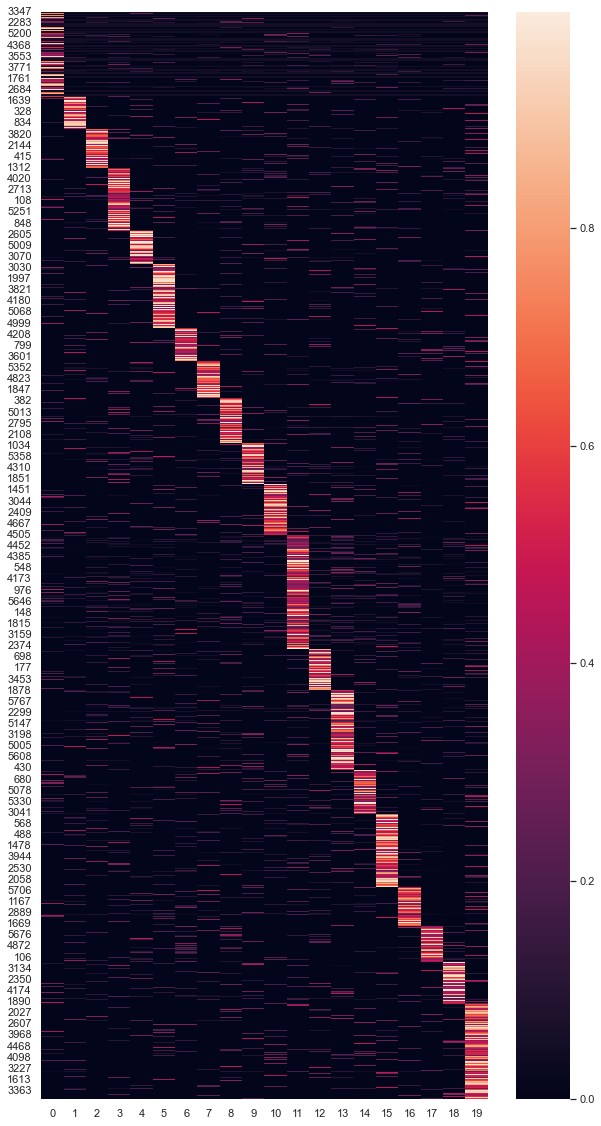

In [67]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index]);

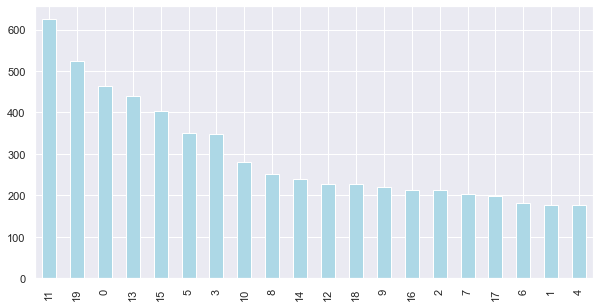

In [69]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue');